# Etude Snorkel / Extration de partenariats d'entreprises
Pour ce projet, nous allons essayer d'extraire des relations de partenariats économiques entre des entreprises depuis des articles. <br/>
Le but étant de comprendre l'utilisation de snorkel.

Nous allons découper notre traitement dans 3 notebooks (chacun correspondant à une étape du pipeline `Snorkel` :
1. Preprocessing
2. Training
3. Evaluation

## Partie II: Génération et modélisation de "_noisy_" labels contenant du bruit

Dans ce notebook, nous allons écrire nos **fonctions de labelisation** pour étiquetter nos données.
Comme ces `Labeling functions` ne seront pas parfaites, nous allons modéliser leur précision avec un modèle _generative_ que `Snorkel` nous permettra d'appliquer.

Nous les utiliserons pour produire un ensemble de label pour nos données d'entrainement. Ces données bien que contenant du bruit, pourront ensuite être appliquer à un modèle de classification.

***

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re

import numpy as np
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels
from snorkel.viewer import SentenceNgramViewer
from snorkel.lf_helpers import test_LF
from snorkel.annotations import load_gold_labels
from snorkel.annotations import LabelAnnotator
from snorkel.learning import GenerativeModel
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,get_text_splits,
    contains_token, rule_text_btw, rule_text_in_span
)

from lib.scoring import *
from lib.lf_factories import *

session = SnorkelSession()

# I. Préparation des données

## 1. Notre schéma

On initialise de nouveau notre relation de partenariat entre 2 entreprises

In [2]:
Partner = candidate_subclass('Partner', ['company1', 'company2'])

## 2. Chargement de notre jeu de données de _development_

Nous chargeons les données qui ont été labelisées manuellement et qui font parties de notre jeu de développement (split = 1)

In [3]:
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

In [4]:
L_gold_dev.shape

(271, 1)

## 3. Data exploration

Analysons nos données pour nous aider à créer les fonctions de labeling.

In [5]:
# load our list of training & development candidates
train_cands = session.query(Partner).filter(Partner.split == 0).all()
dev_cands   = session.query(Partner).filter(Partner.split == 1).all()

SentenceNgramViewer(train_cands, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[393]], [[125, 126, 127, 128, 129, 130, 1084, 1085, 1086, 1087, 1088, 1273, 1274, 1…

# II. Ecriture des fonctions de labelisation (`Labeling Function`)

  
`get_left_tokens(c, window=3, attrib='words', n_max=1, case_sensitive=False)
get_right_tokens(c, window=3, attrib='words', n_max=1, case_sensitive=False)
get_between_tokens(c, attrib='words', n_max=1, case_sensitive=False)
get_text_between(c)
get_tagged_text(c)
get_text_split(c)
contains_token`



### Métriques de nos Labeling Function

####  Coverage
C'est le nombre de candidats labelisés par notre LF sur un jeu de données (entrainement).

####  Precision / Recall / F1
Métriques standard pour les classification : précision, rappel, F1-score

In [6]:
# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

## 1. Concurrences

In [7]:
# search between candidates, compet token for words like (competition, compete, competitive, ...)
def LF_compete(c):
    return -1 if re.search(r'compet', get_text_between(c), flags=re.I) else 0
   
labeled = coverage(session, LF_compete, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_compete, split=1, gold=L_gold_dev)

Coverage: 1.00% (33/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 2 | FN: 0



In [8]:
competitors = {'competitor', 'competitors', 'competitive', 'competition', 'competitions' }
def LF_competitors(c):
    if len(competitors.intersection(get_right_tokens(c[1], window=40))) > 0 :
        return -1
    elif len(competitors.intersection(get_left_tokens(c[0], window=40))) > 0 :
        return -1
    else :
        return 0

labeled = coverage(session, LF_competitors, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_competitors, split=1, gold=L_gold_dev)

Coverage: 3.53% (117/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 10 | FN: 0



In [9]:
against = ['alternative(s)?', 'vs', 'rival(s)?', 'versus', 'surpass(es|ed)?' , 'competitor(s)?']
def LF_against(c):
    return -1 if re.search(r'{{A}}.{0,50} ' + ltp(against) + '.{0,50}{{B}}',get_tagged_text(c) , re.I) else 0

labeled = coverage(session, LF_against, split=0)
tp, fp, tn, fn = error_analysis(session, LF_against, split=1, gold=L_gold_dev)

Coverage: 0.87% (29/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 1 | FN: 0



In [10]:
players = {'players', 'vendors', 'providers', 'provide'}
def LF_players(c) :
    if len(players.intersection(get_left_tokens(c[0], window=20))) > 0 :
        return -1 
    elif len(players.intersection(get_right_tokens(c[1], window=20))) > 0 :
        return -1
    else :
        return 0

labeled = coverage(session, LF_players, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_players, split=1, gold=L_gold_dev)

Coverage: 14.02% (465/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 7 | FN: 0



In [11]:
def LF_comas(c):
    return -1 if re.search(r'{{A}}.{0,3}\,.{0,3}{{B}}', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_comas, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_comas, split=1, gold=L_gold_dev)

Coverage: 6.63% (220/3316)


<IPython.core.display.Javascript object>

LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 3 | FN: 0



## 2. Acquisitions

In [12]:
acquisitions = ['acquir(e|ed|es|ing){1}', 'acquisition','purchase(s|d)?','buy(ing)?', 'bougth'] 

def LG_acquisitions_between(c) :
    return 1 if re.search(r'{{A}}.{0,100} ' + ltp(acquisitions) + '.{0,100}{{B}}', get_tagged_text(c), re.I) else 0
     
labeled = coverage(session, LG_acquisitions_between, split=0)
tp, fp, tn, fn = error_analysis(session, LG_acquisitions_between, split=1, gold=L_gold_dev)

Coverage: 1.30% (43/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 1 | TN: 0 | FN: 0



In [13]:
def LG_acquisition_before(c) :
    return -1 if 'acquisition' in (get_left_tokens(c[0], window=50, case_sensitive=False)) else 0

labeled = coverage(session, LG_acquisition_before, split=0)
tp, fp, tn, fn = error_analysis(session, LG_acquisition_before, split=1, gold=L_gold_dev)

Coverage: 0.63% (21/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 2 | FN: 0



In [14]:
def LF_slash(c):
    return -1 if re.search(r'{{A}}.{0,3}/.{0,3}{{B}}', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_slash, split=0)
tp, fp, tn, fn = error_analysis(session, LF_slash, split=1, gold=L_gold_dev)

Coverage: 0.15% (5/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



## 3. Alias

In [15]:
# same company name
def LG_sameNames(c) :
    c1_name = c.company1.get_span()
    c2_name = c.company2.get_span()
    if c1_name == c2_name:
        return -1
    return 0

labeled = coverage(session, LG_sameNames, split=0)
tp, fp, tn, fn = error_analysis(session, LG_sameNames, split=1, gold=L_gold_dev)

Coverage: 12.03% (399/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 47 | FN: 0



In [16]:
def LG_contains(c) :
    c1_name = c.company1.get_span().lower()
    c2_name = c.company2.get_span().lower()
    return -1 if (c1_name in c2_name or c2_name in c1_name) else 0

    
labeled = coverage(session, LG_contains, split=0)
tp, fp, tn, fn = error_analysis(session, LG_contains, split=1, gold=L_gold_dev)

Coverage: 14.75% (489/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 52 | FN: 0



In [17]:
def LG_sigle(c):
    return -1 if re.search(r'{{A}}.{0,2}\({{B}}\)', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LG_sigle, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LG_sigle, split=1, gold=L_gold_dev)

Coverage: 0.33% (11/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 2 | FN: 0



## 4. Partenariat

In [18]:
def LF_with_relations(c) :
    return 1 if 'with' in get_text_between(c).lower().strip() else 0

def LF_with_relations_and_not_same(c) :
    return 1 if LF_with_relations(c) == 1 and LG_sameNames(c) != -1 else 0

labeled = coverage(session, LF_with_relations_and_not_same, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_with_relations_and_not_same, split=1, gold=L_gold_dev)

Coverage: 13.30% (441/3316)
LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.867
Recall               1.0
F1                   0.929
----------------------------------------
TP: 26 | FP: 4 | TN: 0 | FN: 0



In [19]:
cooperations = ['partner(ed|s|ing)?', 'partnership(s)?','collaborat(e|es|ed|ion|ing){1}',
                'cooperat(e|es|ed|ion|ing){1}', 'associat(e|es|ed|ing|ion){1}',  'relationship(s)?',
                'work(s,|ed|ing)?'] 


def LF_cooperations_btw(c):
    return 1 if re.search(r'{{A}}.{0,100} ' + ltp(cooperations) + '.{0,100}{{B}}', get_tagged_text(c), re.I) else 0

def LF_cooperations_btw_and_not_same(c) :
    return 1 if LF_cooperations_btw(c) == 1 and LG_sameNames(c) != -1 else 0

labeled = coverage(session, LF_cooperations_btw_and_not_same, split=0)
tp, fp, tn, fn = error_analysis(session, LF_cooperations_btw_and_not_same, split=1, gold=L_gold_dev)

Coverage: 6.97% (231/3316)
LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.833
Recall               1.0
F1                   0.909
----------------------------------------
TP: 10 | FP: 2 | TN: 0 | FN: 0



In [20]:
relations = ['partner', 'collaborat','cooperat', 
             'associat',  'relation', 'join', 'alliance', 'unit'] 

def LF_relations_in_sentence(c) :
    return 1 if re.search(r''+ ltp(relations), get_tagged_text(c), re.I) else 0


def LF_relations_in_sentence_and_not_same(c) :
    return 1 if LF_relations_in_sentence(c) == 1 and LG_sameNames(c) != -1 else 0


labeled = coverage(session, LF_relations_in_sentence_and_not_same, split=0)
tp, fp, tn, fn = error_analysis(session, LF_relations_in_sentence_and_not_same, split=1, gold=L_gold_dev)
SentenceNgramViewer(fp, session, n_per_page=1)

Coverage: 32.33% (1072/3316)
LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 18 | FP: 0 | TN: 0 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\n…

In [21]:
def LF_alliances(c) :
    alliances = {'alliance', 'alliances', 'jointly', 'join', 'association', 'associations'}
    if len(alliances.intersection(get_left_tokens(c[0], window=50, case_sensitive=False))) > 0 :
        return 1
    elif len(alliances.intersection(get_right_tokens(c[1], window=50, case_sensitive=False))) > 0 :
        return 1
    else :
        return 0

    
def LF_alliances_and_not_same(c) :
    return 1 if LF_alliances(c) == 1 and LG_sameNames(c) != -1 else 0


labeled = coverage(session, LF_alliances_and_not_same, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_alliances_and_not_same, split=1, gold=L_gold_dev)

Coverage: 8.08% (268/3316)


<IPython.core.display.Javascript object>

LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 1 | FP: 0 | TN: 0 | FN: 0



In [22]:
def LF_and(c):
    return 1 if re.search(r'{{A}}.{0,5}and.{0,5}{{B}}', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_and, split=0)
tp, fp, tn, fn = error_analysis(session, LF_and, split=1, gold=L_gold_dev)

Coverage: 4.64% (154/3316)
LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.4
Recall               1.0
F1                   0.571
----------------------------------------
TP: 4 | FP: 6 | TN: 0 | FN: 0



## 5. Procès

In [23]:
trials = [ ' su(ed|ing){1}', 'lawsuit(s)?', 'claim(s|ed)?', 'legal', 'jury', 'court(s)?',
          'patent(s)', 'violate(s|d)?', 'allege(s|d)?' ] 

def LF_trial_in_sentence(c) :
    return -1 if re.search(r''+ ltp(trials), get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_trial_in_sentence, split=0)
tp, fp, tn, fn = error_analysis(session, LF_trial_in_sentence, split=1, gold=L_gold_dev)

Coverage: 1.63% (54/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 2 | FN: 0



## 6. Clients

In [24]:
def LF_clients(c):
    clients = {'on', 'by', 'from'}
    return -1 if len(clients.intersection(get_left_tokens(c[1], window=3))) > 0 else 0


labeled = coverage(session, LF_clients, split=0)
tp, fp, tn, fn = error_analysis(session, LF_clients, split=1, gold=L_gold_dev)

Coverage: 5.79% (192/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 7 | FN: 2



In [25]:
def LF_test(c):
    return -1 if re.search(r'{{A}}.{0,5}or.{0,5}{{B}}', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_test, split=0)
tp, fp, tn, fn = error_analysis(session, LF_test, split=1, gold=L_gold_dev)

Coverage: 0.24% (8/3316)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



# III. Application de nos fonctions de labelisation

## 1. Préparation des fonctions

On regroupe toutes les fonctions dans une liste.

In [38]:
LFs = [
    LF_compete,
    LF_competitors,
    LF_against,
    LF_players,
    LG_acquisitions_between,
    LG_acquisition_before,
    LF_slash,
    LG_sameNames,
    LG_contains,
    LG_sigle,
    LF_with_relations_and_not_same,
    LF_cooperations_btw_and_not_same,
    LF_relations_in_sentence_and_not_same,
    LF_alliances_and_not_same,
#    LF_and,
    LF_trial_in_sentence,
    LF_clients,
    LF_comas,
#    LF_test
]

Ensuite nous appliquons nos LFs sur nos candidats d'entrainement afin de produire un ensemble de labels. 

In [39]:
labeler = LabelAnnotator(lfs=LFs)

## 2. Génération de la matrice de _labels_

In [40]:
%time L_train = labeler.apply(split=0, lfs=LFs, parallelism=1)
print("Train shape :", L_train.shape)

%time L_dev = labeler.apply_existing(split=1, lfs=LFs, parallelism=1)
print("Dev shape :",L_dev.shape)

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 22.1 s, sys: 258 ms, total: 22.3 s
Wall time: 22.9 s
Train shape : (3316, 17)
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 2.85 s, sys: 126 ms, total: 2.97 s
Wall time: 2.97 s
Dev shape : (271, 17)


In [41]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_compete,0,0.009952,0.007539,0.004524
LF_competitors,1,0.035283,0.026538,0.006031
LF_against,2,0.008745,0.006031,0.002714
LF_players,3,0.140229,0.066647,0.030760
LG_acquisitions_between,4,0.012967,0.009952,0.006936
LG_acquisition_before,5,0.006333,0.006333,0.006333
LF_slash,6,0.001508,0.000905,0.000603
LG_sameNames,7,0.120326,0.120326,0.000905
LG_contains,8,0.147467,0.135103,0.013872
LG_sigle,9,0.003317,0.001809,0.000905


## 3. Label Matrix Empirical Accuracies

In [42]:
import warnings
warnings.filterwarnings("ignore")
L_dev.lf_stats(session, labels=L_gold_dev.toarray().ravel())

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_compete,0,0.007380,0.007380,0.00000,0,0,0,2,1.000000
LF_competitors,1,0.040590,0.025830,0.00000,0,0,0,10,1.000000
LF_against,2,0.003690,0.000000,0.00000,0,0,0,1,1.000000
LF_players,3,0.118081,0.070111,0.00738,0,0,0,7,1.000000
LG_acquisitions_between,4,0.018450,0.003690,0.00369,0,1,0,0,0.000000
LG_acquisition_before,5,0.011070,0.011070,0.00000,0,0,0,2,1.000000
LF_slash,6,0.000000,0.000000,0.00000,0,0,0,0,NaN
LG_sameNames,7,0.173432,0.173432,0.00000,0,0,0,47,1.000000
LG_contains,8,0.191882,0.184502,0.00000,0,0,0,52,1.000000
LG_sigle,9,0.007380,0.000000,0.00000,0,0,0,2,1.000000


# IV. Entrainement du _generative_ modèle

## 1. Entrainement du modèle

In [43]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(L_train,  decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0)

Inferred cardinality: 2


## 2. Précision du modèle

In [44]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_compete,0,0.007380,0.007380,0.00000,0,0,0,2,1.000000,0.587743
LF_competitors,1,0.040590,0.025830,0.00000,0,0,0,10,1.000000,0.599739
LF_against,2,0.003690,0.000000,0.00000,0,0,0,1,1.000000,0.591676
LF_players,3,0.118081,0.070111,0.00738,0,0,0,7,1.000000,0.640016
LG_acquisitions_between,4,0.018450,0.003690,0.00369,0,1,0,0,0.000000,0.605812
LG_acquisition_before,5,0.011070,0.011070,0.00000,0,0,0,2,1.000000,0.593326
LF_slash,6,0.000000,0.000000,0.00000,0,0,0,0,NaN,0.595333
LG_sameNames,7,0.173432,0.173432,0.00000,0,0,0,47,1.000000,0.660962
LG_contains,8,0.191882,0.184502,0.00000,0,0,0,52,1.000000,0.658035
LG_sigle,9,0.007380,0.000000,0.00000,0,0,0,2,1.000000,0.578714


## 3. Probabilités marginales

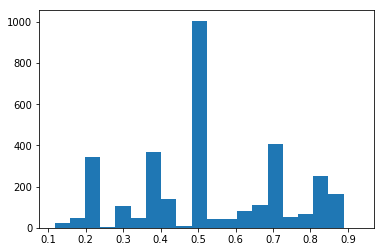

In [45]:
train_marginals = gen_model.marginals(L_train)
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [46]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.589852,0.4513,0.591809,0.255768
1,0.606294,0.4544,0.604591,0.277645
2,0.590340,0.4555,0.598222,0.267701
3,0.634132,0.5010,0.639068,0.316229
4,0.585440,0.4588,0.590393,0.268894
5,0.601437,0.4594,0.600088,0.271281
6,0.596456,0.4515,0.598350,0.274065
7,0.659462,0.4904,0.667634,0.320406
8,0.648992,0.4960,0.657165,0.330151
9,0.594807,0.4583,0.588692,0.271281


In [47]:
dev_marginals = gen_model.marginals(L_dev)

In [48]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.614
Neg. class accuracy: 0.902
Precision            0.625
Recall               0.614
F1                   0.619
----------------------------------------
TP: 35 | FP: 21 | TN: 193 | FN: 22



In [49]:
SentenceNgramViewer(fp, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[5]], [[1]], [[2]], [[18, 19]], [[0, 10, 11]], [[3]], [[6, 7]], [[4, 8, 9, 12]], [[…